# Cross-Validation plots (Extra Figure for Reviewers)

## Before you start

This notebook assumes that the cross-validation analyses, up to and including `evaluate_errors.sh` has already been run.
In addition, we require the prior_comparisons script to be finished.

The data are expected to be located in the directory `../datasets/gibson/cross_validation`.

In [41]:
from typing import *
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import itertools

import scipy.stats
from statsmodels.stats.multitest import fdrcorrection

from matplotlib.patches import Patch, Rectangle
import matplotlib.transforms as mtransforms
import string

# Make font editable in AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [35]:
def annot_pvalue(ax, pvalue, x1, x2, y, h, color='black', log_scale=False, text_label=None, fontsize: float=5.):
    # statistical annotation
    grid_x = np.array([x1, x1, x2, x2])
    grid_y = np.array([0.5*h, 1.5*h, 1.5*h, 0.5*h])
    if log_scale:
        grid_y = np.exp(np.log10(y) + grid_y)
    else:
        grid_y = y + grid_y
    ax.plot(grid_x, grid_y, lw=0.7, c=color)
    
    if text_label is not None:
        text_x = 0.5 * (x1 + x2)
        # text_y = grid_y[0]
        if log_scale:
            text_y = np.exp(np.log10(y) + 1.5 * h)
        else:
            text_y = y + 0.6 * h
        t = ax.text(
            text_x, text_y, text_label, ha='center', va='bottom', color=color, size=fontsize
        )


def make_boxplot(
    ax, 
    df: pd.DataFrame,
    method_order: List[str],
    method_labels: Dict[str, str],
    method_colors: Dict[str, np.ndarray],
    lb: float,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    eps: float = 0.0,
    test_paired: bool = True,
    pval_fontsize: float = 5.0
):
    def agg_fn(_df):
        _df = _df.loc[_df['Truth'] > lb]
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps

        err = np.sqrt(np.mean(np.square(
            np.log10(pred) - np.log10(truth)
        )))  # Root mean squared?
        return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] > lb, :]
    df = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx']).apply(agg_fn).reset_index()
    df = df.loc[
        df['Method'].isin(method_order)
    ].sort_values(
        by='Method',
        key=lambda col: col.map({m: i for i, m in enumerate(method_order)})
    )

    sns.boxplot(
        data=df,
        ax=ax,
        x='Method',
        y='Error',
        showfliers=False,
        palette=method_colors,
        whis=(2.5, 97.5)
    )

    labels = [
        ''
        for item in ax.get_xticklabels()
    ]
    ax.set_xticklabels(labels)

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    # ====================== P-value annotations =========================
    entries = []
    for (x1, m1), (x2, m2) in itertools.combinations(enumerate(method_order), 2):
        _x = df.loc[df['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
        _y = df.loc[df['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
        _k = (~np.isnan(_x)) & (~np.isnan(_y))
        _x = _x[_k]
        _y = _y[_k]
        if test_paired:
            _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
        else:
            _stat, _pval = scipy.stats.mannwhitneyu(_x, _y, alternative='two-sided')
        entries.append({
            'Method1': m1,
            'Method2': m2,
            'x1': x1,
            'x2': x2,
            'p': _pval
        })
    pval_df = pd.DataFrame(entries)

    y_annot = np.quantile(df.dropna()['Error'], q=0.99)
    _, bh_pvals = fdrcorrection(pval_df['p'])
    pval_df['bh'] = bh_pvals
    
    # ==== p-value annotation render.
    j = 0
    for idx, row in pval_df.iterrows():
        if row['bh'] > 0.05:
            c = '#FA8072'
            lbl = 'ns'
        elif row['bh'] > 0.01:
            c = 'black'
            lbl = '*'
        elif row['bh'] > 0.001:
            c = 'black'
            lbl = '**'
        elif row['bh'] > 0.0001:
            c = 'black'
            lbl = '***'
        else:
            c = 'black'
            lbl = '****'
        annot_pvalue(ax, row['bh'], x1=row['x1'], x2=row['x2'], y=y_annot + 0.2 * (j), h=0.05, color=c, text_label=lbl, fontsize=pval_fontsize)    
        j += 1
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    return pval_df
    


def make_grouped_boxplot(
    bin_ax, error_ax,
    df,
    method_order: List[str],
    method_labels: Dict[str, str],
    method_colors: Dict[str, np.ndarray],
    lb: float,
    num_bins: int = 10,
    error_ylabel: Optional[str] = None,
    eps: float = 0.0,
    bin_xlabel: str = 'concentration'
):
    def agg_fn(_df):
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps

        err = np.sqrt(np.mean(np.square(
            np.log10(pred) - np.log10(truth)
        )))  # Root mean squared?
        
        _method = _df.head(1)['Method'].item()
        if np.isnan(err.item()):
            return np.nan
        return err
        # return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] > lb]
    df = df.assign(Bin=pd.qcut(
        np.log10(df['Truth']),
        q=num_bins,
        duplicates='drop'
    ))

    df_agg_entries = []
    for (m, s, t, b), d in df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx', 'Bin']):
        err = agg_fn(d)
        df_agg_entries.append({
            'Method': m,
            'HeldoutSubjectIdx': s,
            'TaxonIdx': t,
            'Bin': b,
            'Error': err
        })
    df_agg = pd.DataFrame(df_agg_entries)
    del df_agg_entries
    # df_agg = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx', 'Bin']).apply(agg_fn).reset_index()
    

    # ============ Render bin counts.
    def _aggregate_abundances_bin(_df):
        _bin = _df.head(1)['Bin'].item()
        count = sum(1 for _ in _df.groupby(['HeldoutSubjectIdx', 'TaxonIdx', 'TimePoint']))
        return pd.Series({
            'Left': _bin.left,
            'Right': _bin.right,
            'Count': count
        })
    bin_counts = df.groupby('Bin').apply(_aggregate_abundances_bin)
    widths = bin_counts['Right'] - bin_counts['Left']
    
    xmin = bin_counts['Left'].min()
    xmax = bin_counts['Right'].max()
    y = 0.0
    h = 0.5
    r = 0.7 * (2 * h)
    eps = 0.01
    
    bin_ax.set_xlim([xmin-eps, xmax+eps])
    bin_ax.set_ylim([y-h, y+h])
    boundaries = set()
    bin_indices = {}
    
    for b_idx, (_, row) in enumerate(bin_counts.iterrows()):
        x1 = row['Left']
        x2 = row['Right']
        boundaries.add(x1)
        boundaries.add(x2)
        bin_indices[x1] = b_idx
        
        xm = 0.5 * (x1 + x2)
        bin_ax.plot([x1, x2], [y, y], label='', color='black', linewidth=1.0, zorder=0)
        bin_ax.plot([x1, x1], [y - h, y + h], label='', color='black', linewidth=1.0, zorder=0)
        bin_ax.text(xm, y, f'{b_idx + 1}', ha='center', va='center', zorder=2, color='black', fontsize=8)
        
        x1 = row['Left']
        x2 = row['Right']
        xm = 0.5 * (x1 + x2)
        
        # calculate the aspect ratio
        xscale, yscale = bin_ax.transData.transform([1, 1]) - bin_ax.transData.transform([0, 0])
        
        radius_y = r
        radius_x = radius_y * yscale / xscale
        bin_ax.add_patch(patches.Ellipse((xm, y), radius_x, radius_y, color='white', alpha=1.0, zorder=1, linewidth=0.8, ec='black'))
    bin_ax.plot([xmax, xmax], [y - h, y + h], label='', color='black', linewidth=1.0, zorder=0)
    
    def sci_format(x):
        x = np.power(10, x)
        a, b = '{:.2E}'.format(x).split('E')
        return r'{:.1f}$ \times 10^{{{:1d}}}$'.format(float(a), int(b))
    
    boundaries = sorted(boundaries)
    bin_ax.set_yticks([])
    bin_ax.set_xticks(boundaries)
    bin_ax.set_xticklabels([sci_format(b) for b in boundaries], rotation=45, ha='right')
    bin_ax.set_xlabel(bin_xlabel)
    bin_ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    bin_ax.tick_params(length=0)
    
    
    # ============= Render RMSE.
    def _bin_label(interval):
        b_idx = bin_indices[interval.left]
        return f'{b_idx + 1}'
    df_agg['BinLabel'] = df_agg['Bin'].map(_bin_label)
    df_agg = df_agg.sort_values('Bin')
    supported_methods = set(pd.unique(df_agg['Method']))
    method_order = [m for m in method_order if m in supported_methods]
    sns.boxplot(
        data=df_agg,
        ax=error_ax,
        x='BinLabel',
        y='Error',
        hue='Method', hue_order=method_order, palette=method_colors,
        showfliers=False,
        whis=(2.5, 97.5)
    )
    error_ax.set_axisbelow(True)
    error_ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    error_ax.set_xlabel('Bin number')
    if error_ylabel is not None:
        error_ax.set_ylabel(error_ylabel)

    error_ax.get_legend().remove()

def make_zeros_geometricmean_boxplot(ax,
                        df,
                        method_order: List[str],
                        method_labels: Dict[str, str],
                        method_colors: Dict[str, np.ndarray],
                        lb: float,
                        num_bins: int = 10,
                        error_ylabel: Optional[str] = None,
                        eps: float = 0.0,
                        annot_dy: float = 0.5,
                        annot_h: float = 0.5):
    def agg_fn(_df):
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps
        
        # == geometric mean
        err = np.mean(np.log10(pred))
        return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] < lb]
    df_agg = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx']).apply(agg_fn).reset_index()
    supported_methods = set(pd.unique(df_agg['Method']))
    method_order = [m for m in method_order if m in supported_methods]
    df_agg = df_agg.loc[
        df_agg['Method'].isin(method_order)
    ].sort_values(
        by='Method',
        key=lambda col: col.map({m: i for i, m in enumerate(method_order)})
    )

    # ============= Render RMSE.
    sns.boxplot(
        data=df_agg,
        x='Method',
        ax=ax,
        y='Error',
        palette=method_colors,
        showfliers=False,
        whis=(2.5, 97.5)
    )
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    ax.set_xlabel('')
    if error_ylabel is not None:
        ax.set_ylabel(error_ylabel)

    labels = [
        method_labels[item.get_text()]
        for item in ax.get_xticklabels()
    ]
    ax.set_xticklabels(labels)

## Load metrics

In [3]:
base_dir = Path('/data/cctm/youn/MDSINE2_Paper/datasets/gibson/cross_validation')

subdirs = {
    'Default-old': 'mdsine2-modules', 
    'Edge-Density-1': base_dir / 'edge_density_1',
    'Edge-Density-2': base_dir / 'edge_density_2',
    'Edge-Density-3': base_dir / 'edge_density_3',
    'Edge-Density-4': base_dir / 'edge_density_4',
    'Edge-Density-5': base_dir / 'edge_density_5',
    'Growth-SI-Var-1': base_dir / 'growth_si_var_1',
    'Growth-SI-Var-2': base_dir / 'growth_si_var_2',
    'Growth-SI-Var-3': base_dir / 'growth_si_var_3',
    'Growth-SI-Var-4': base_dir / 'growth_si_var_4',
    'Interaction-Var-1': base_dir / 'interaction_var_1',
    'Interaction-Var-2': base_dir / 'interaction_var_2',
    'Interaction-Var-3': base_dir / 'interaction_var_3',
    'Interaction-Var-4': base_dir / 'interaction_var_4',
    'Pert-Var-1': base_dir / 'pert_var_1',
    'Pert-Var-2': base_dir / 'pert_var_2',
    'Pert-Var-3': base_dir / 'pert_var_3',
    'Pert-Var-4': base_dir / 'pert_var_4',
    # 'Dense-Sparsity': 'mdsine2-modules-interaction-density-dense',
    # 'Sparse-Sparsity': 'mdsine2-modules-interaction-density-sparse',
    # 'Medium-Sparsity': 'mdsine2-modules-interaction-density-medium',
    # 'Positive-Strength': 'mdsine2-modules-interaction-strength-positive',
    # 'Negative-Strength': 'mdsine2-modules-interaction-strength-negative',
    # 'Zero-Strength': 'mdsine2-modules-interaction-strength-zero',
    # 'Zero-Strength-TINYSCALE2': 'mdsine2-modules-interaction-strength-zero-TINYSCALE2',
    # 'Zero-Strength-TINYSCALE3': 'mdsine2-modules-interaction-strength-zero-TINYSCALE3',
    # 'Default2': 'mdsine2-modules-default',
    # # 'Zero-Master': 'mdsine2-modules-interaction-strength-zero-MASTER',
    # 'Zero-Rerun': 'mdsine2-modules-interaction-strength-zero-RERUN',
    # 'Default-SICS-Medium': 'mdsine2-modules-default-sics-medium',
    # 'Default-SICS-Small': 'mdsine2-modules-default-sics-small',
    # 'mh-Learn': 'mdsine2-modules-mhlearn',
    # 'mh-Learn2': 'mdsine2-modules-mhlearn2',
    # 'Zero-Strength-lowdof': 'mdsine2-modules-interaction-strength-zero-lowdof',
    # 'PertInteractionScale': 'mdsine2-modules-inter-var-smallscale'
}

# .assign(Method='Elastic-Net')
elastic_net_abs_df = pd.read_csv(Path('/data/local/MDSINE2_Paper/datasets/gibson/healthy/cross_validation/absolute_cv.tsv'), sep='\t')
elastic_net_abs_df = elastic_net_abs_df.loc[elastic_net_abs_df['Method'] == 'gLV (elastic net)'].assign(Method='Elastic-Net')

abs_df = pd.concat([
    pd.read_csv(base_dir / subdir / "absolute_cv.tsv", sep='\t').assign(Method=prior_name)
    for prior_name, subdir in subdirs.items()
] + [
    elastic_net_abs_df
])
# rel_df = pd.concat([
#     pd.read_csv(base_dir / subdir / "relative_cv.tsv", sep='\t').assign(Method=prior_name)
#     for prior_name, subdir in subdirs.items()
# ])

# Figure - All together, Absolute unbinned metrics

In [28]:
def render_math(ax, math_text: str, fontsize: int):
    matplotlib.rcParams['text.usetex'] = True
    matplotlib.pyplot.rc('text.latex', preamble=r'\usepackage{amsmath,xcolor}')
    ax.text(0.5, 0.1, math_text, fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')
    ax.axis('off')
    matplotlib.rcParams['text.usetex'] = False
    

def render_boxplot_and_legend(ax, legend_ax, prior_order, prior_labels, lb=1e-5, eps=1e-5):
    palette_tab20 = sns.color_palette("tab20", len(prior_order))
    prior_colors = {m: palette_tab20[i] for i, m in enumerate(prior_order)}
    prior_colors['Elastic-Net'] = 'gray'
    
    # UNBINNED BOXPLOT
    pval_df = make_boxplot(
        ax, abs_df, prior_order, prior_labels, prior_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', 
        lb=lb, eps=eps, test_paired=True, pval_fontsize=8.0
    )
    ax.set_xticks([])
    
    pval_df = pval_df.drop(columns=['x1', 'x2'])
    pval_df['Method1'] = pval_df['Method1'].map(prior_labels)
    pval_df['Method2'] = pval_df['Method2'].map(prior_labels)

    # LEGEND
    legend_ax.axis('off')
    legend_elements = [
        Patch(facecolor=prior_colors[_m], edgecolor='black', label=prior_labels[_m], linewidth=0.5)
        for _m in prior_order
    ]
    legend_ax.legend(
        handles=legend_elements, ncol=2, bbox_to_anchor=(0.5, 1.0), loc='upper center'
    )
    return pval_df

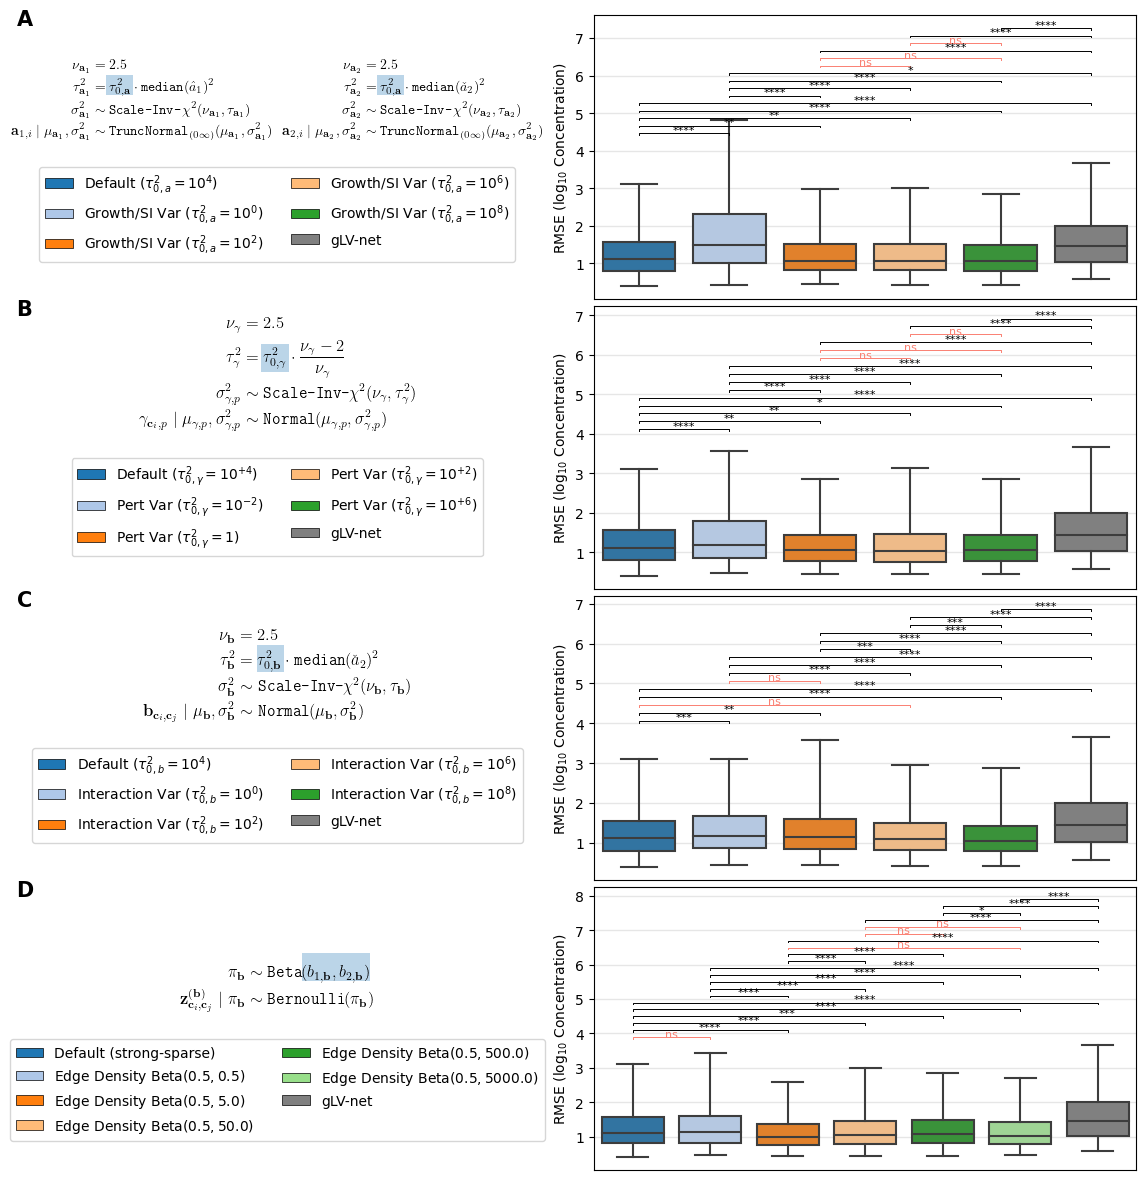

In [48]:
# layout = [
#     ["EdgeDensityMath",   "InteractionVarMath"],
#     ["EdgeDensityPlot",   "InteractionVarPlot"],
#     ["EdgeDensityLegend", "InteractionVarLegend"],
#     ["GrowthSIVarMath", "PertVarMath"],
#     ["GrowthSIVarPlot", "PertVarPlot"],
#     ["GrowthSIVarLegend", "PertVarLegend"]
# ]
layout = [
    ["GrowthSIVarMath_1", "GrowthSIVarMath_2", "GrowthSIVarPlot"],
    ["GrowthSIVarLegend", "GrowthSIVarLegend", "GrowthSIVarPlot"],
    ["PertVarMath",   "PertVarMath",   "PertVarPlot"],
    ["PertVarLegend", "PertVarLegend", "PertVarPlot"],
    ["InteractionVarMath",   "InteractionVarMath",   "InteractionVarPlot"],
    ["InteractionVarLegend", "InteractionVarLegend", "InteractionVarPlot"],
    ["EdgeDensityMath",   "EdgeDensityMath",   "EdgeDensityPlot"],
    ["EdgeDensityLegend", "EdgeDensityLegend", "EdgeDensityPlot"],
]
ax_labels = {
    "healthy_abs": "A1",
    "healthy_rel": "A2",
    "uc_abs": "B1",
    "uc_rel": "B2",
}
fig, axes = plt.subplot_mosaic(
    layout, figsize=(14, 15),
    gridspec_kw={
        'height_ratios': [1, 1, 1, 1, 1, 1, 1, 1],
        'width_ratios': [1, 1, 3],
        'wspace': 0.3,
        'hspace': 0.05
    }
)


render_math(
    axes['EdgeDensityMath'], 
    r"\begin{align*}"
    r"\pi_\mathbf{b} &\sim \texttt{Beta}(b_{1,\mathbf b}, b_{2,\mathbf b}) \\"
    r"\mathbf{z}^{(\mathbf b)}_{\mathbf c_i, \mathbf c_j} \mid \pi_\mathbf{b} & \sim \texttt{Bernoulli} (\pi_\mathbf{b})" 
    r"\end{align*}",
    fontsize=12
)
axes['EdgeDensityMath'].add_patch(Rectangle((0.555, 0.32), width=0.15, height=0.2, alpha=0.3, clip_on=False))
_ = render_boxplot_and_legend(
    axes['EdgeDensityPlot'], axes['EdgeDensityLegend'],
    ['Default', 'Edge-Density-1', 'Edge-Density-2', 'Edge-Density-3', 'Edge-Density-4', 'Edge-Density-5', 'Elastic-Net'],
    {
        'Default': r'Default (strong-sparse)',
        'Edge-Density-1': r'Edge Density Beta$(0.5,0.5)$',
        'Edge-Density-2': r'Edge Density Beta$(0.5,5.0)$',
        'Edge-Density-3': r'Edge Density Beta$(0.5,50.0)$',
        'Edge-Density-4': r'Edge Density Beta$(0.5,500.0)$',
        'Edge-Density-5': r'Edge Density Beta$(0.5,5000.0)$',
        'Elastic-Net': r'gLV-net'
    }
)


render_math(
    axes['InteractionVarMath'], 
    r"\begin{align*}"
    r"\nu_{\mathbf{b}} &=  2.5 \\"
    r"\tau_{\mathbf{b}}^2 &= \tau_{0,\mathbf{b}}^2 \cdot \texttt{median}(\check a_2)^2 \\"
    r"\sigma^2_{\mathbf{b}}  & \sim\texttt{Scale-Inv-}\chi^2(\nu_{\mathbf{b}},\tau_{\mathbf{b}}) \\"
    r"\mathbf b_{\mathbf{c}_i,\mathbf{c}_j} \mid \mu_{\mathbf{b}}, \sigma^2_{\mathbf{b}}  & \sim\texttt{Normal}(\mu_{\mathbf{b}}, \sigma^2_{\mathbf{b}})"
    r"\end{align*}",
    fontsize=12
)
axes['InteractionVarMath'].add_patch(Rectangle((0.455, 0.45), width=0.06, height=0.2, alpha=0.3, clip_on=False))
_ = render_boxplot_and_legend(
    axes['InteractionVarPlot'], axes['InteractionVarLegend'],
    ['Default', 'Interaction-Var-1', 'Interaction-Var-2', 'Interaction-Var-3', 'Interaction-Var-4', 'Elastic-Net'],
    {
        'Default': r'Default ($\tau_{0,b}^2 = 10^{4}$)',
        'Interaction-Var-1': r'Interaction Var ($\tau_{0,b}^2 = 10^{0}$)',
        'Interaction-Var-2': r'Interaction Var ($\tau_{0,b}^2 = 10^{2}$)',
        'Interaction-Var-3': r'Interaction Var ($\tau_{0,b}^2 = 10^{6}$)',
        'Interaction-Var-4': r'Interaction Var ($\tau_{0,b}^2 = 10^{8}$)',
        'Elastic-Net': r'gLV-net'
    }
)


render_math(
    axes['PertVarMath'], 
    r"\begin{align*}"
    r"\nu_\gamma & =  2.5 \\"
    r"\tau_\gamma^2 & =  \tau_{0,\gamma}^2 \cdot \frac{\nu_\gamma-2}{\nu_\gamma} \\"
    r"\sigma^2_{\gamma,p}  & \sim\texttt{Scale-Inv-}\chi^2(\nu_\gamma,\tau_\gamma^2) \\"
    r"\gamma_{\mathbf{c}_i,p} \mid \mu_{\gamma,p}, \sigma^2_{\gamma,p}  & \sim\texttt{Normal}(\mu_{\gamma,p}, \sigma^2_{\gamma,p})"
    r"\end{align*}",
    fontsize=12
)
axes['PertVarMath'].add_patch(Rectangle((0.465, 0.52), width=0.06, height=0.2, alpha=0.3, clip_on=False))
_ = render_boxplot_and_legend(
    axes['PertVarPlot'], axes['PertVarLegend'],
    ['Default', 'Pert-Var-1', 'Pert-Var-2', 'Pert-Var-3', 'Pert-Var-4', 'Elastic-Net'],
    {
        'Default': r'Default ($\tau_{0,\gamma}^2=10^{+4}$)',
        'Pert-Var-1': r'Pert Var ($\tau_{0,\gamma}^2=10^{-2}$)',
        'Pert-Var-2': r'Pert Var ($\tau_{0,\gamma}^2=1$)',
        'Pert-Var-3': r'Pert Var ($\tau_{0,\gamma}^2=10^{+2}$)',
        'Pert-Var-4': r'Pert Var ($\tau_{0,\gamma}^2=10^{+6}$)',
        'Elastic-Net': r'gLV-net'
    }
)

render_math(
    axes['GrowthSIVarMath_1'],
    r"\begin{align*}"
    r"\nu_{\mathbf a_1} &= 2.5 \\"
    r"\tau_{\mathbf a_1}^2 &= \tau_{0,\mathbf a}^2 \cdot \texttt{median}(\hat a_1)^2 \\"
    r"\sigma^2_{\mathbf a_1} &\sim \texttt{Scale-Inv-}\chi^2(\nu_{\mathbf a_1},\tau_{\mathbf a_1}) \\"
    r"\mathbf a_{1,i} \mid \mu_{\mathbf a_1}, \sigma^2_{\mathbf a_1}  & \sim\texttt{TruncNormal}_{(0\infty)}(\mu_{\mathbf a_1}, \sigma^2_{\mathbf a_1})"
    r"\end{align*}",
    fontsize=10
)
axes['GrowthSIVarMath_1'].add_patch(Rectangle((0.3, 0.42), width=0.15, height=0.15, alpha=0.3, clip_on=False))
render_math(
    axes['GrowthSIVarMath_2'],
    r"\begin{align*}"
    r"\nu_{\mathbf a_2} &= 2.5 \\"
    r"\tau_{\mathbf a_2}^2 & =  \tau_{0,\mathbf a}^2 \cdot \texttt{median}(\check a_2)^2 \\"
    r"\sigma^2_{\mathbf a_2}  & \sim\texttt{Scale-Inv-}\chi^2(\nu_{\mathbf a_2},\tau_{\mathbf a_2}) \\"
    r"\mathbf a_{2,i} \mid \mu_{\mathbf a_2}, \sigma^2_{\mathbf a_2}  & \sim\texttt{TruncNormal}_{(0\infty)}(\mu_{\mathbf a_2}, \sigma^2_{\mathbf a_2})"
    r"\end{align*}",
    fontsize=10
)
axes['GrowthSIVarMath_2'].add_patch(Rectangle((0.3, 0.42), width=0.15, height=0.15, alpha=0.3, clip_on=False))

_ = render_boxplot_and_legend(
    axes['GrowthSIVarPlot'], axes['GrowthSIVarLegend'],
    ['Default', 'Growth-SI-Var-1', 'Growth-SI-Var-2', 'Growth-SI-Var-3', 'Growth-SI-Var-4', 'Elastic-Net'],
    {
        'Default': r'Default ($\tau_{0,a}^2 = 10^{4}$)',
        'Growth-SI-Var-1': r'Growth/SI Var ($\tau_{0,a}^2 = 10^{0}$)',
        'Growth-SI-Var-2': r'Growth/SI Var ($\tau_{0,a}^2 = 10^{2}$)',
        'Growth-SI-Var-3': r'Growth/SI Var ($\tau_{0,a}^2 = 10^{6}$)',
        'Growth-SI-Var-4': r'Growth/SI Var ($\tau_{0,a}^2 = 10^{8}$)',
        'Elastic-Net': r'gLV-net'
    }
)
for n, _ax in enumerate([axes['GrowthSIVarMath_1'], axes['PertVarMath'], axes['InteractionVarMath'], axes['EdgeDensityMath']]):
    trans = mtransforms.ScaledTranslation(-25/72, -10/72, fig.dpi_scale_trans)
    _ax.text(0, 1, string.ascii_uppercase[n], transform=_ax.transAxes + trans,
             va='bottom', fontfamily='sans-serif', weight='bold', size=15)

plt.savefig("plots/prior_comparison_unbinned.pdf", bbox_inches='tight')

# Absolute abundance metrics

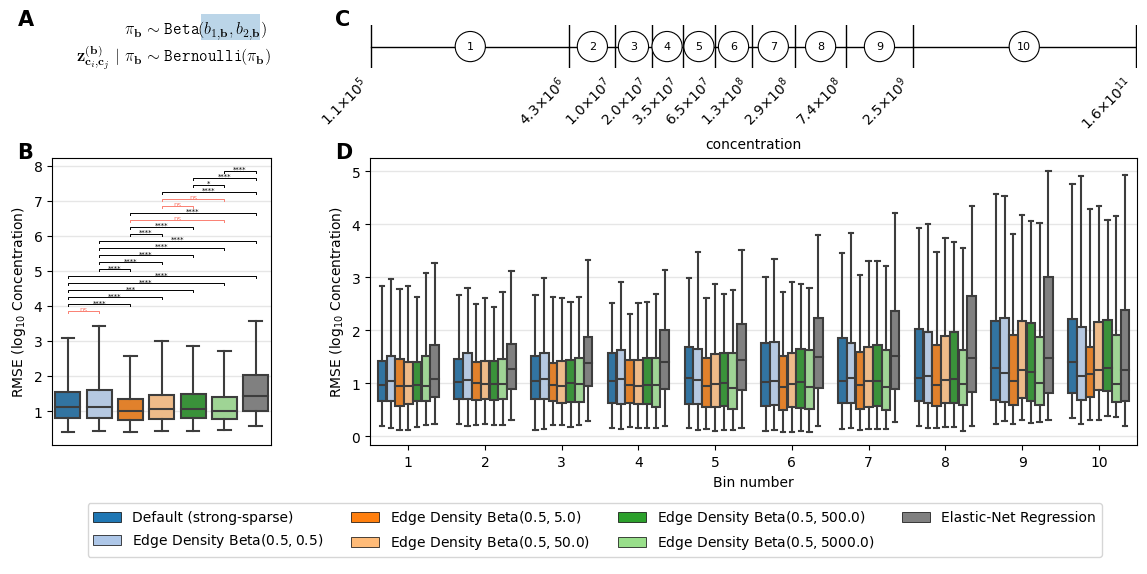

In [34]:
prior_order = [
    'Default', 
    'Edge-Density-1',
    'Edge-Density-2',
    'Edge-Density-3',
    'Edge-Density-4',
    'Edge-Density-5',
    'Elastic-Net'
]
prior_labels = {
    'Default': r'Default (strong-sparse)',
    'Edge-Density-1': r'Edge Density Beta$(0.5,0.5)$',
    'Edge-Density-2': r'Edge Density Beta$(0.5,5.0)$',
    'Edge-Density-3': r'Edge Density Beta$(0.5,50.0)$',
    'Edge-Density-4': r'Edge Density Beta$(0.5,500.0)$',
    'Edge-Density-5': r'Edge Density Beta$(0.5,5000.0)$',
    'Elastic-Net': r'Elastic-Net Regression'
}
palette_tab20 = sns.color_palette("tab20", len(prior_order))
prior_colors = {m: palette_tab20[i] for i, m in enumerate(prior_order)}
prior_colors['Elastic-Net'] = 'gray'


fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 3.5], height_ratios=[1.5, 10, 1], hspace=0.75)
ax = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),  # unbinned plot
    fig.add_subplot(gs[0, 1:]),  # quantiles
    fig.add_subplot(gs[1, 1:]),  # binned nonzeroes
]

matplotlib.rcParams['text.usetex'] = True
matplotlib.pyplot.rc('text.latex', preamble=r'\usepackage{amsmath}')
ax[0].text(
    1, 0, 
    r"\begin{align*}"
    r"\pi_\mathbf{b} &\sim \texttt{Beta}(b_{1,\mathbf b}, b_{2,\mathbf b}) \\"
    r"\mathbf{z}^{(\mathbf b)}_{\mathbf c_i, \mathbf c_j} \mid \pi_\mathbf{b} & \sim \texttt{Bernoulli} (\pi_\mathbf{b})" 
    r"\end{align*}", 
    fontsize=12, 
    horizontalalignment='right',
    verticalalignment='bottom'
)
ax[0].axis('off')
matplotlib.rcParams['text.usetex'] = False
ax[0].add_patch(
    Rectangle((0.68, 0.65), width=0.27, height=0.6, alpha=0.3, clip_on=False)
)


for n, _ax in enumerate(ax):
    trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
    _ax.text(0, 1, string.ascii_uppercase[n], transform=_ax.transAxes + trans,
             va='bottom', fontfamily='sans-serif', weight='bold', size=15)

num_bins = 10
lb = 1e-5
ub = 1e40
eps = 1e-5
pval_df = make_boxplot(ax[1], abs_df, prior_order, prior_labels, prior_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=eps, test_paired=True)
ax[1].set_xticks([])
make_grouped_boxplot(ax[2], ax[3], abs_df, prior_order, prior_labels, prior_colors, num_bins=num_bins, error_ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=eps)
pval_df = pval_df.drop(columns=['x1', 'x2'])
pval_df['Method1'] = pval_df['Method1'].map(prior_labels)
pval_df['Method2'] = pval_df['Method2'].map(prior_labels)


# ==================== legend
legend_ax = fig.add_subplot(gs[2, :])
legend_ax.axis('off')
legend_elements = [
    Patch(facecolor=prior_colors[_m], edgecolor='black', label=prior_labels[_m], linewidth=0.5)
    for _m in prior_order
]
legend_ax.legend(
    handles=legend_elements, ncol=4, bbox_to_anchor=(0.5, 0.0), loc='lower center'
)

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
plt.savefig(plots_dir / "prior_comparison_edge_density.pdf", bbox_inches='tight')
pval_df.to_csv(plots_dir / "prior_comparison_edge_density.tsv", sep='\t', index=False)

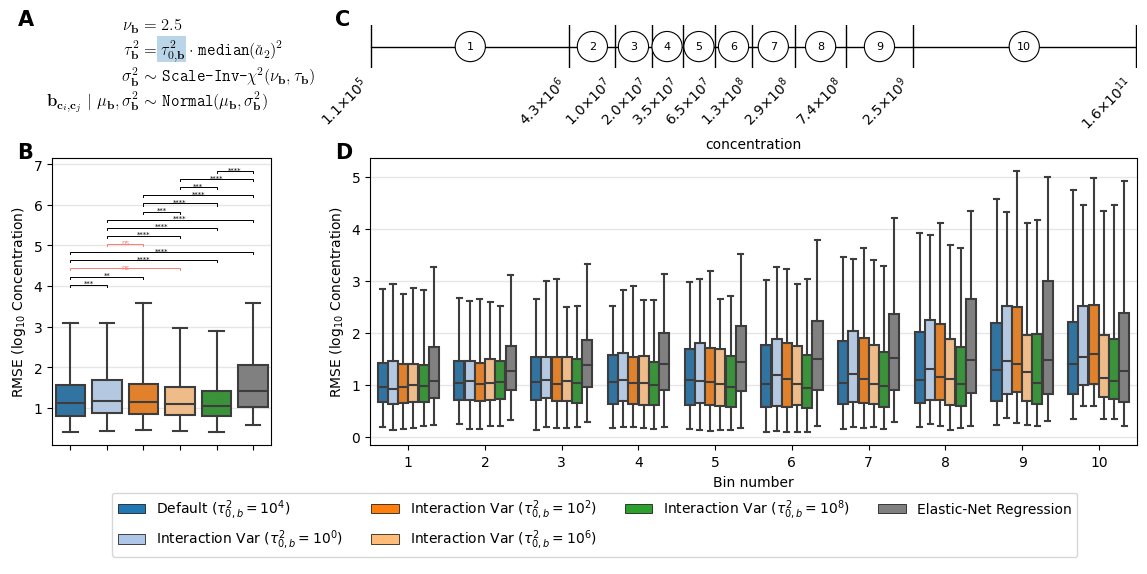

In [35]:
prior_order = [
    'Default', 
    'Interaction-Var-1',
    'Interaction-Var-2',
    'Interaction-Var-3',
    'Interaction-Var-4',
    'Elastic-Net'
]
prior_labels = {
    'Default': r'Default ($\tau_{0,b}^2 = 10^{4}$)',
    'Interaction-Var-1': r'Interaction Var ($\tau_{0,b}^2 = 10^{0}$)',
    'Interaction-Var-2': r'Interaction Var ($\tau_{0,b}^2 = 10^{2}$)',
    'Interaction-Var-3': r'Interaction Var ($\tau_{0,b}^2 = 10^{6}$)',
    'Interaction-Var-4': r'Interaction Var ($\tau_{0,b}^2 = 10^{8}$)',
    'Elastic-Net': r'Elastic-Net Regression'
}
palette_tab20 = sns.color_palette("tab20", len(prior_order))
prior_colors = {m: palette_tab20[i] for i, m in enumerate(prior_order)}
prior_colors['Elastic-Net'] = 'gray'


fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 3.5], height_ratios=[1.5, 10, 1], hspace=0.75)
ax = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),  # unbinned plot
    fig.add_subplot(gs[0, 1:]),  # quantiles
    fig.add_subplot(gs[1, 1:]),  # binned nonzeroes
]

matplotlib.rcParams['text.usetex'] = True
matplotlib.pyplot.rc('text.latex', preamble=r'\usepackage{amsmath}')
ax[0].text(
    1.2, -1.0,
    r"\begin{align*}"
    r"\nu_{\mathbf{b}} &=  2.5 \\"
    r"\tau_{\mathbf{b}}^2 &= \tau_{0,\mathbf{b}}^2 \cdot \texttt{median}(\check a_2)^2 \\"
    r"\sigma^2_{\mathbf{b}}  & \sim\texttt{Scale-Inv-}\chi^2(\nu_{\mathbf{b}},\tau_{\mathbf{b}}) \\"
    r"\mathbf b_{\mathbf{c}_i,\mathbf{c}_j} \mid \mu_{\mathbf{b}}, \sigma^2_{\mathbf{b}}  & \sim\texttt{Normal}(\mu_{\mathbf{b}}, \sigma^2_{\mathbf{b}})"
    r"\end{align*}", 
    fontsize=12, 
    horizontalalignment='right',
    verticalalignment='bottom'
)
ax[0].axis('off')
matplotlib.rcParams['text.usetex'] = False
ax[0].add_patch(
    Rectangle((0.48, 0.15), width=0.13, height=0.6, alpha=0.3, clip_on=False)
)


for n, _ax in enumerate(ax):
    trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
    _ax.text(0, 1, string.ascii_uppercase[n], transform=_ax.transAxes + trans,
             va='bottom', fontfamily='sans-serif', weight='bold', size=15)

num_bins = 10
lb = 1e-5
ub = 1e40
eps = 1e-5
pval_df = make_boxplot(ax[1], abs_df, prior_order, prior_labels, prior_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=eps, test_paired=True)
make_grouped_boxplot(ax[2], ax[3], abs_df, prior_order, prior_labels, prior_colors, num_bins=num_bins, error_ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=eps)
pval_df = pval_df.drop(columns=['x1', 'x2'])
pval_df['Method1'] = pval_df['Method1'].map(prior_labels)
pval_df['Method2'] = pval_df['Method2'].map(prior_labels)

# ==================== legend
legend_ax = fig.add_subplot(gs[2, :])
legend_ax.axis('off')
legend_elements = [
    Patch(facecolor=prior_colors[_m], edgecolor='black', label=prior_labels[_m], linewidth=0.5)
    for _m in prior_order
]
legend_ax.legend(
    handles=legend_elements, ncol=4, bbox_to_anchor=(0.5, 0.0), loc='lower center'
)

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
plt.savefig(plots_dir / "prior_comparison_interaction_var.pdf", bbox_inches='tight')
pval_df.to_csv(plots_dir / "prior_comparison_interaction_var.tsv", sep='\t', index=False)

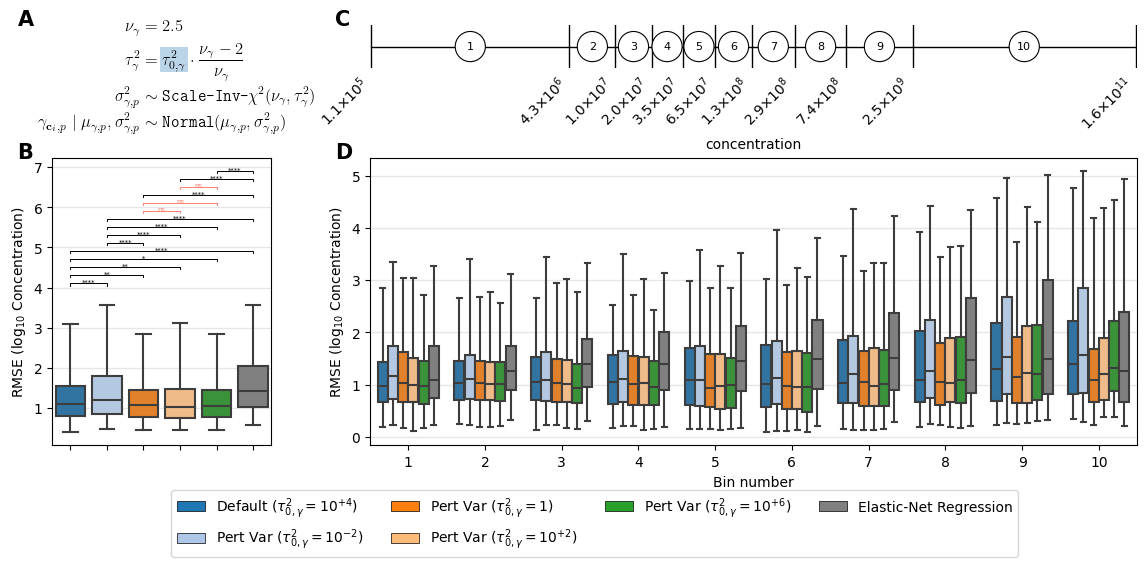

In [36]:
prior_order = [
    'Default', 
    'Pert-Var-1',
    'Pert-Var-2',
    'Pert-Var-3',
    'Pert-Var-4',
    'Elastic-Net'
]
prior_labels = {
    'Default': r'Default ($\tau_{0,\gamma}^2=10^{+4}$)',
    'Pert-Var-1': r'Pert Var ($\tau_{0,\gamma}^2=10^{-2}$)',
    'Pert-Var-2': r'Pert Var ($\tau_{0,\gamma}^2=1$)',
    'Pert-Var-3': r'Pert Var ($\tau_{0,\gamma}^2=10^{+2}$)',
    'Pert-Var-4': r'Pert Var ($\tau_{0,\gamma}^2=10^{+6}$)',
    'Elastic-Net': r'Elastic-Net Regression'
}
palette_tab20 = sns.color_palette("tab20", len(prior_order))
prior_colors = {m: palette_tab20[i] for i, m in enumerate(prior_order)}
prior_colors['Elastic-Net'] = 'gray'


fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 3.5], height_ratios=[1.5, 10, 1], hspace=0.75)
ax = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),  # unbinned plot
    fig.add_subplot(gs[0, 1:]),  # quantiles
    fig.add_subplot(gs[1, 1:]),  # binned nonzeroes
]

matplotlib.rcParams['text.usetex'] = True
matplotlib.pyplot.rc('text.latex', preamble=r'\usepackage{amsmath}')
ax[0].text(
    1.2, -1.5,
    r"\begin{align*}"
    r"\nu_\gamma & =  2.5 \\"
    r"\tau_\gamma^2 & =  \tau_{0,\gamma}^2 \cdot \frac{\nu_\gamma-2}{\nu_\gamma} \\"
    r"\sigma^2_{\gamma,p}  & \sim\texttt{Scale-Inv-}\chi^2(\nu_\gamma,\tau_\gamma^2) \\"
    r"\gamma_{\mathbf{c}_i,p} \mid \mu_{\gamma,p}, \sigma^2_{\gamma,p}  & \sim\texttt{Normal}(\mu_{\gamma,p}, \sigma^2_{\gamma,p})"
    r"\end{align*}", 
    fontsize=12, 
    horizontalalignment='right',
    verticalalignment='bottom'
)
ax[0].axis('off')
matplotlib.rcParams['text.usetex'] = False
ax[0].add_patch(
    Rectangle((0.49, -0.10), width=0.13, height=0.6, alpha=0.3, clip_on=False)
)


for n, _ax in enumerate(ax):
    trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
    _ax.text(0, 1, string.ascii_uppercase[n], transform=_ax.transAxes + trans,
             va='bottom', fontfamily='sans-serif', weight='bold', size=15)

num_bins = 10
lb = 1e-5
ub = 1e40
eps = 1e-5
pval_df = make_boxplot(ax[1], abs_df, prior_order, prior_labels, prior_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=eps, test_paired=True)
make_grouped_boxplot(ax[2], ax[3], abs_df, prior_order, prior_labels, prior_colors, num_bins=num_bins, error_ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=eps)
pval_df = pval_df.drop(columns=['x1', 'x2'])
pval_df['Method1'] = pval_df['Method1'].map(prior_labels)
pval_df['Method2'] = pval_df['Method2'].map(prior_labels)

# ==================== legend
legend_ax = fig.add_subplot(gs[2, :])
legend_ax.axis('off')
legend_elements = [
    Patch(facecolor=prior_colors[_m], edgecolor='black', label=prior_labels[_m], linewidth=0.5)
    for _m in prior_order
]
legend_ax.legend(
    handles=legend_elements, ncol=4, bbox_to_anchor=(0.5, 0.0), loc='lower center'
)

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
plt.savefig(plots_dir / "prior_comparison_perturbation_var.pdf", bbox_inches='tight')
pval_df.to_csv(plots_dir / "prior_comparison_perturbation_var.tsv", sep='\t', index=False)

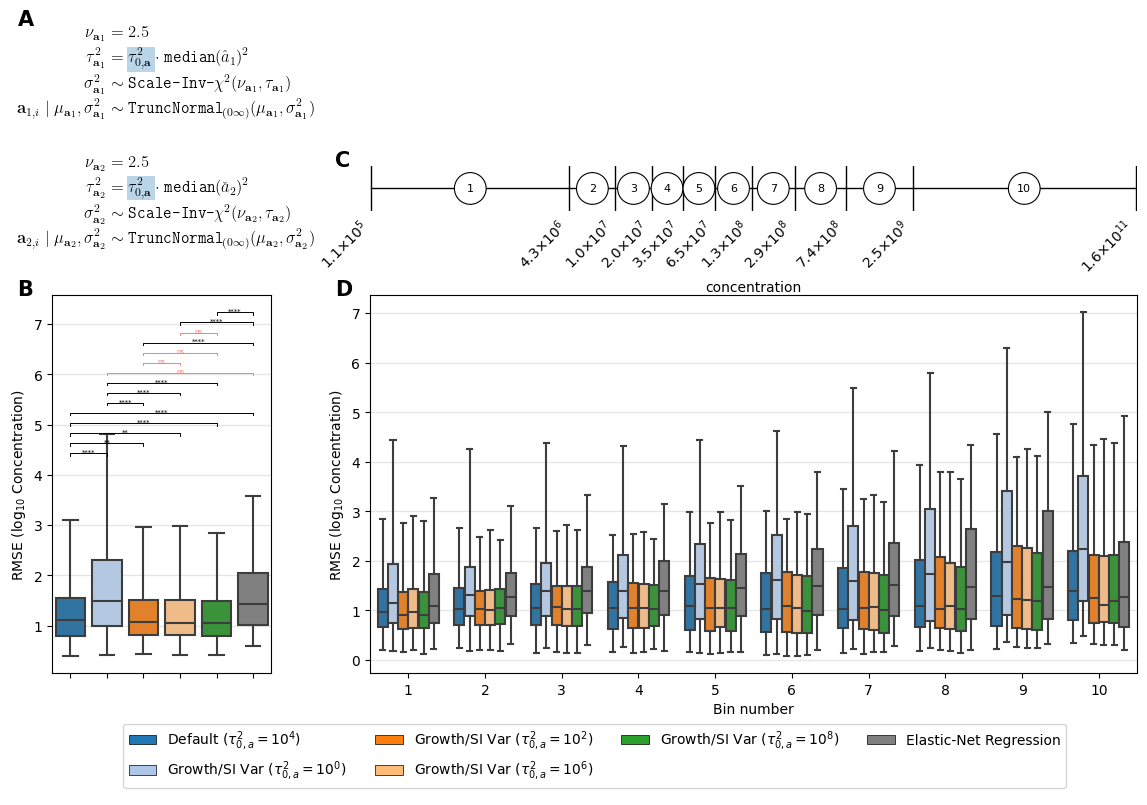

In [37]:
prior_order = [
    'Default', 
    'Growth-SI-Var-1',
    'Growth-SI-Var-2',
    'Growth-SI-Var-3',
    'Growth-SI-Var-4',
    'Elastic-Net'
]
prior_labels = {
    'Default': r'Default ($\tau_{0,a}^2 = 10^{4}$)',
    'Growth-SI-Var-1': r'Growth/SI Var ($\tau_{0,a}^2 = 10^{0}$)',
    'Growth-SI-Var-2': r'Growth/SI Var ($\tau_{0,a}^2 = 10^{2}$)',
    'Growth-SI-Var-3': r'Growth/SI Var ($\tau_{0,a}^2 = 10^{6}$)',
    'Growth-SI-Var-4': r'Growth/SI Var ($\tau_{0,a}^2 = 10^{8}$)',
    'Elastic-Net': r'Elastic-Net Regression'
}
palette_tab20 = sns.color_palette("tab20", len(prior_order))
prior_colors = {m: palette_tab20[i] for i, m in enumerate(prior_order)}
prior_colors['Elastic-Net'] = 'gray'


fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(4, 2, width_ratios=[1, 3.5], height_ratios=[1.5, 1.2, 10, 1], hspace=0.65)
ax = [
    fig.add_subplot(gs[0:2, 0]),
    fig.add_subplot(gs[2, 0]),  # unbinned plot
    fig.add_subplot(gs[1, 1:]),  # quantiles
    fig.add_subplot(gs[2, 1:]),  # binned nonzeroes
]

matplotlib.rcParams['text.usetex'] = True
ax[0].text(
    1.2, 0.5,
    r"\begin{align*}"
    r"\nu_{\mathbf a_1} &= 2.5 \\"
    r"\tau_{\mathbf a_1}^2 &= \tau_{0,\mathbf a}^2 \cdot \texttt{median}(\hat a_1)^2 \\"
    r"\sigma^2_{\mathbf a_1} &\sim \texttt{Scale-Inv-}\chi^2(\nu_{\mathbf a_1},\tau_{\mathbf a_1}) \\"
    r"\mathbf a_{1,i} \mid \mu_{\mathbf a_1}, \sigma^2_{\mathbf a_1}  & \sim\texttt{TruncNormal}_{(0\infty)}(\mu_{\mathbf a_1}, \sigma^2_{\mathbf a_1})"
    r"\end{align*}", 
    fontsize=12, 
    horizontalalignment='right',
    verticalalignment='bottom'
)
ax[0].axis('off')
ax[0].add_patch(
    Rectangle((0.34, 0.75), width=0.13, height=0.13, alpha=0.3, clip_on=False)
)

ax[0].text(
    1.2, -0.2,
    r"\begin{align*}"
    r"\nu_{\mathbf a_2} &= 2.5 \\"
    r"\tau_{\mathbf a_2}^2 & =  \tau_{0,\mathbf a}^2 \cdot \texttt{median}(\check a_2)^2 \\"
    r"\sigma^2_{\mathbf a_2}  & \sim\texttt{Scale-Inv-}\chi^2(\nu_{\mathbf a_2},\tau_{\mathbf a_2}) \\"
    r"\mathbf a_{2,i} \mid \mu_{\mathbf a_2}, \sigma^2_{\mathbf a_2}  & \sim\texttt{TruncNormal}_{(0\infty)}(\mu_{\mathbf a_2}, \sigma^2_{\mathbf a_2})"
    r"\end{align*}", 
    fontsize=12, 
    horizontalalignment='right',
    verticalalignment='bottom'
)
ax[0].add_patch(
    Rectangle((0.34, 0.06), width=0.13, height=0.13, alpha=0.3, clip_on=False)
)
matplotlib.rcParams['text.usetex'] = False


for n, _ax in enumerate(ax):
    trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
    _ax.text(0, 1, string.ascii_uppercase[n], transform=_ax.transAxes + trans,
             va='bottom', fontfamily='sans-serif', weight='bold', size=15)

num_bins = 10
lb = 1e-5
ub = 1e40
eps = 1e-5
pval_df = make_boxplot(ax[1], abs_df, prior_order, prior_labels, prior_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=eps, test_paired=True)
make_grouped_boxplot(ax[2], ax[3], abs_df, prior_order, prior_labels, prior_colors, num_bins=num_bins, error_ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=eps)
pval_df = pval_df.drop(columns=['x1', 'x2'])
pval_df['Method1'] = pval_df['Method1'].map(prior_labels)
pval_df['Method2'] = pval_df['Method2'].map(prior_labels)

# ==================== legend
legend_ax = fig.add_subplot(gs[-1, :])
legend_ax.axis('off')
legend_elements = [
    Patch(facecolor=prior_colors[_m], edgecolor='black', label=prior_labels[_m], linewidth=0.5)
    for _m in prior_order
]
legend_ax.legend(
    handles=legend_elements, ncol=4, bbox_to_anchor=(0.5, 0.0), loc='lower center'
)

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
plt.savefig(plots_dir / "prior_comparison_growth_si_var.pdf", bbox_inches='tight')
pval_df.to_csv(plots_dir / "prior_comparison_growth_si_var.tsv", sep='\t', index=False)